# pattern recognation project (IMDB Movie review Sentenment classification)

In [16]:
#import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from keras.optimizers import RMSprop

#display images
from PIL import Image
import requests



In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

17464789/17464789 [==============================] - 1s 0us/step
25000 train sequences
25000 test sequences


In [ ]:
X_train.describe()


In [3]:
#each integer represents a specific word in the dictionary
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
INDEX_FROM = 3
word_index = imdb.get_word_index()
word_index = {key:(value+INDEX_FROM) for key,value in word_index.items()}
word_index["<PAD>"] = 0    # the padding token
word_index["<START>"] = 1  # the starting token
word_index["<UNK>"] = 2    # the unknown token
reverse_word_index = {value:key for key, value in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(X_train[0])
decode_review(X_train[0])

1641221/1641221 [==============================] - 1s 0us/step


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

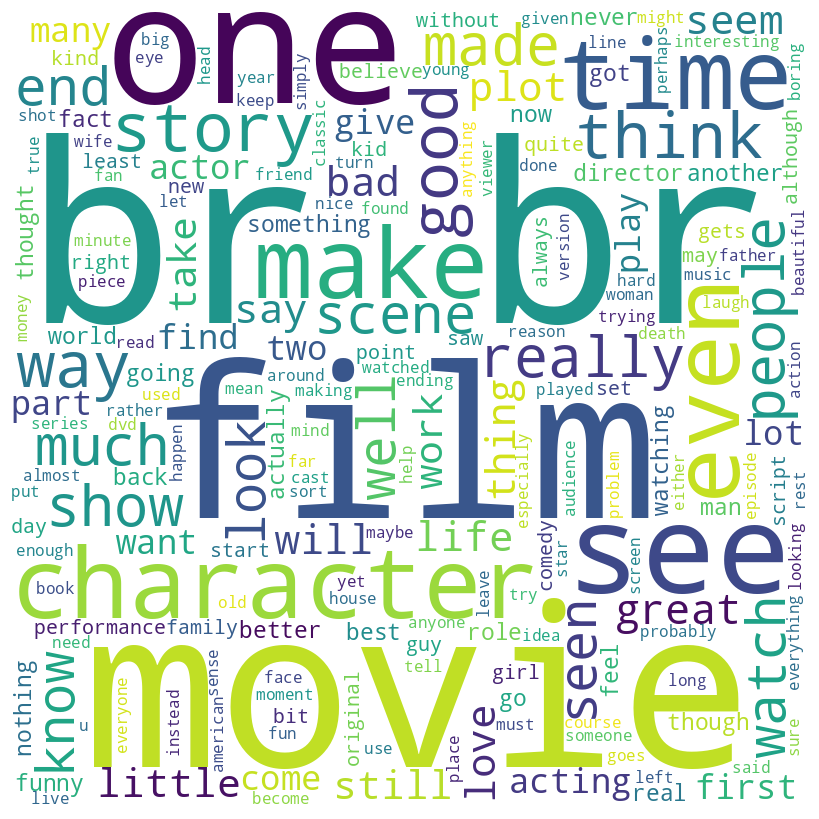

In [21]:

# Get the word index dictionary
word_index = imdb.get_word_index()

# Reverse the word index dictionary
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decode the review text from the integer sequence
def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

# Decode the reviews in the training set
decoded_reviews = [decode_review(text) for text in X_train]

# Concatenate all the reviews into a single string
all_reviews = ' '.join(decoded_reviews)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

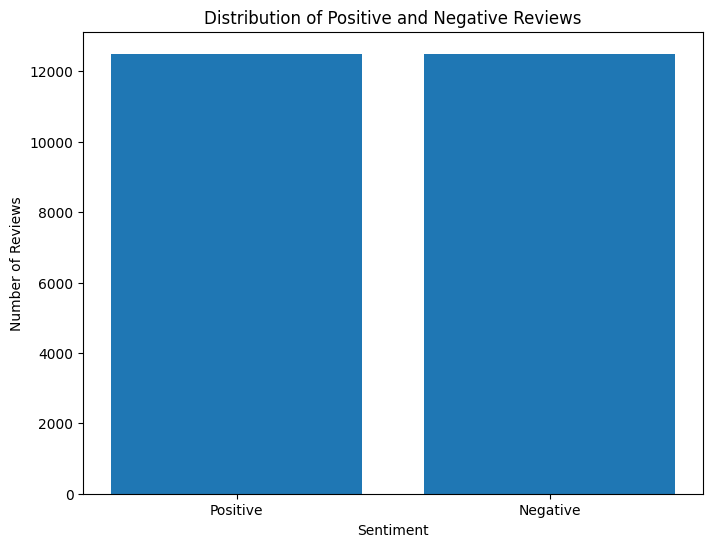

In [5]:
import numpy as np

# Calculate the number of positive and negative reviews
pos_count = np.sum(y_train == 1)
neg_count = np.sum(y_train == 0)

# Plot the distribution of positive and negative reviews
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [pos_count, neg_count])
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

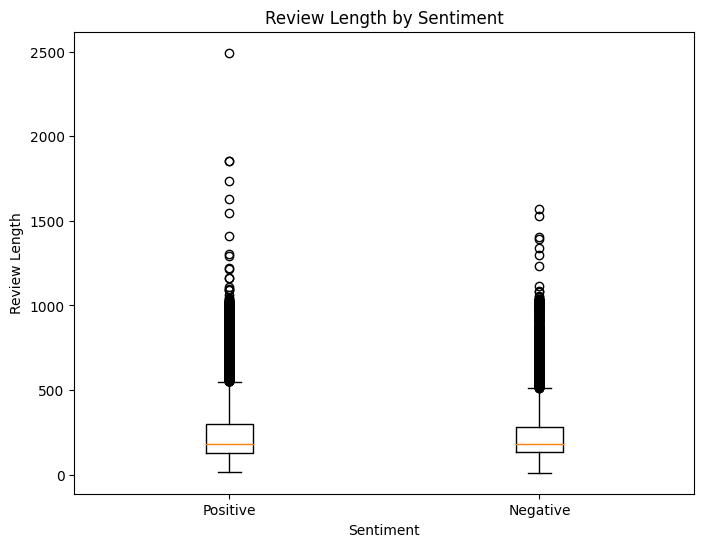

In [6]:

pos_lengths = [len(review) for i, review in enumerate(X_train) if y_train[i] == 1]
neg_lengths = [len(review) for i, review in enumerate(X_train) if y_train[i] == 0]

# Plot a box plot of review length by sentiment
plt.figure(figsize=(8, 6))
plt.boxplot([pos_lengths, neg_lengths], labels=['Positive', 'Negative'])
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()


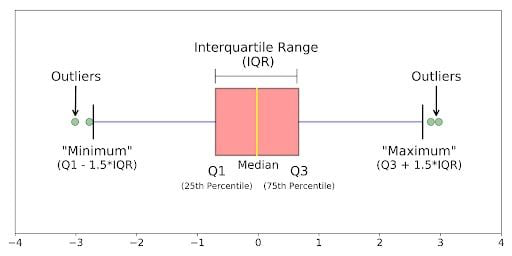

In [7]:

url = 'https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/1_boxplots.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im

In [8]:
#split and prepare the data for the cnn model
#5,000 most common words. I will also consider 20% of the training set for validation purpose.
vocab_size = 5000 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words= vocab_size)

X_train, X_val = X_train[:-5000], X_train[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]

print(len(X_train), 'train sequences')
print(len(X_val), 'val sequences')
print(len(X_test), 'test sequences')

20000 train sequences
5000 val sequences
25000 test sequences


In [9]:

print('X_train shape:', X_train.shape) # (n_samples, n_timesteps)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (20000,)
X_val shape: (5000,)
X_test shape: (25000,)


In [10]:
#Movie reviews can be different lengths. We will use the pad_sequences function to standardize the lengths of the reviews.
#from keras.preprocessing.sequence import pad_sequences

maximum_sequence_length = 500 # maximum length of all review sequences

X_train = pad_sequences(X_train, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_val = pad_sequences(X_val, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_test = pad_sequences(X_test, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)

print('X_train shape:', X_train.shape) # (n_samples, n_timesteps)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)


X_train shape: (20000, 500)
X_val shape: (5000, 500)
X_test shape: (25000, 500)


In [11]:
#check the first padded review.
print(X_train[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
    2   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117    2   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194    2   18    4  226   22   21  134  476
   26  480    5  144   30    2   18   51   36   28  224   92   25  104
    4 

# Train and validate first **model**


In [12]:
# Set hyperparameters
#embedding_dim = 16
#filters = 64
#kernel_size = 3
#strides = 1
#units = 256
#rate = 0.25
#kernel_initializer = 'glorot_uniform'

# Set optimizer
#optimizer = 'adam'
embedding_dim = 16

def create_model(filters = 64, kernel_size = 3, strides=1, units = 256, 
                 optimizer='adam', rate = 0.25, kernel_initializer ='glorot_uniform'):
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_length= maximum_sequence_length))
    # Convolutional Layer(s)
    model.add(Dropout(rate))
    model.add(Conv1D(filters = filters, kernel_size = kernel_size, strides= strides, 
    padding='same', activation= 'relu'))
    model.add(GlobalMaxPooling1D())
    # Dense layer(s)
    model.add(Dense(units = units, activation= 'relu', kernel_initializer= kernel_initializer))
    model.add(Dropout(rate))
    # Output layer
    model.add(Dense(1, activation= 'sigmoid'))
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer= optimizer,
                  metrics=['accuracy'])
    return model
# Build the model
model = KerasClassifier(build_fn= create_model)

<ipython-input-12-70706b5980d8>:35: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn= create_model)


In [13]:
# Train the model on the training dataset
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test dataset using the score method
accuracy = model.score(X_test, y_test)

# Print the test accuracy
print('Test accuracy:', accuracy)

Epoch 1/10
625/625 [==============================] - 29s 44ms/step - loss: 0.5118 - accuracy: 0.7262 - val_loss: 0.3435 - val_accuracy: 0.8493
Epoch 2/10
625/625 [==============================] - 39s 63ms/step - loss: 0.3095 - accuracy: 0.8697 - val_loss: 0.3130 - val_accuracy: 0.8675
Epoch 3/10
625/625 [==============================] - 25s 40ms/step - loss: 0.2423 - accuracy: 0.9014 - val_loss: 0.2833 - val_accuracy: 0.8820
Epoch 4/10
625/625 [==============================] - 25s 40ms/step - loss: 0.2069 - accuracy: 0.9166 - val_loss: 0.2875 - val_accuracy: 0.8788
Epoch 5/10
625/625 [==============================] - 29s 47ms/step - loss: 0.1818 - accuracy: 0.9280 - val_loss: 0.2949 - val_accuracy: 0.8810
Epoch 6/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1546 - accuracy: 0.9416 - val_loss: 0.3087 - val_accuracy: 0.8797
Epoch 7/10
625/625 [==============================] - 25s 39ms/step - loss: 0.1334 - accuracy: 0.9480 - val_loss: 0.3470 - val_accuracy:

Epoch 1/10
625/625 [==============================] - 27s 42ms/step - loss: 0.5051 - accuracy: 0.7276 - val_loss: 0.3393 - val_accuracy: 0.8529
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 0.2973 - accuracy: 0.8742 - val_loss: 0.2821 - val_accuracy: 0.8822
Epoch 3/10
625/625 [==============================] - 25s 40ms/step - loss: 0.2386 - accuracy: 0.9032 - val_loss: 0.2805 - val_accuracy: 0.8833
Epoch 4/10
625/625 [==============================] - 25s 40ms/step - loss: 0.1994 - accuracy: 0.9205 - val_loss: 0.2893 - val_accuracy: 0.8847
Epoch 5/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1726 - accuracy: 0.9327 - val_loss: 0.3007 - val_accuracy: 0.8801
Epoch 6/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1545 - accuracy: 0.9414 - val_loss: 0.3023 - val_accuracy: 0.8822
Epoch 7/10
625/625 [==============================] - 25s 40ms/step - loss: 0.1321 - accuracy: 0.9493 - val_loss: 0.3186 - val_accuracy:

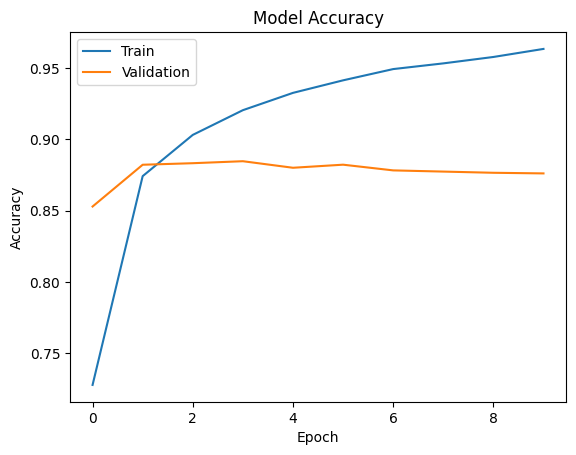

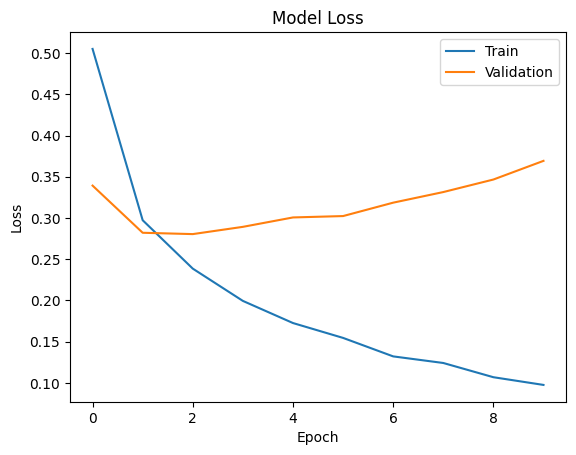

In [18]:
# Train the model on the training dataset
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Get the underlying Keras model
keras_model = model.model

# Evaluate the model on the test dataset
loss, accuracy = keras_model.evaluate(X_test, y_test)

# Print the test accuracy
print('Test accuracy:', accuracy)

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# **Evaluate and train the second model**

In [19]:
# Define new optimizer and hyperparameters
from keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.001)
filters = 128
kernel_size = 5
units = 128

# Build the model
second_model = Sequential()
second_model.add(Embedding(vocab_size, embedding_dim, input_length=maximum_sequence_length))
second_model.add(Dropout(0.25))
second_model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
second_model.add(GlobalMaxPooling1D())
second_model.add(Dense(units=units, activation='relu', kernel_initializer='glorot_uniform'))
second_model.add(Dropout(0.25))
second_model.add(Dense(1, activation='sigmoid'))

# Compile the model with the new optimizer
second_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
# Train the model on the training dataset
history = second_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test dataset
loss, accuracy = second_model.evaluate(X_test, y_test)

# Print the test accuracy
print('Test accuracy:', accuracy)

Epoch 1/10
625/625 [==============================] - 46s 72ms/step - loss: 0.5061 - accuracy: 0.7358 - val_loss: 0.3472 - val_accuracy: 0.8519
Epoch 2/10
625/625 [==============================] - 44s 71ms/step - loss: 0.3201 - accuracy: 0.8641 - val_loss: 0.2853 - val_accuracy: 0.8792
Epoch 3/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2638 - accuracy: 0.8928 - val_loss: 0.2751 - val_accuracy: 0.8861
Epoch 4/10
625/625 [==============================] - 45s 72ms/step - loss: 0.2429 - accuracy: 0.9028 - val_loss: 0.2529 - val_accuracy: 0.8973
Epoch 5/10
625/625 [==============================] - 42s 68ms/step - loss: 0.2178 - accuracy: 0.9155 - val_loss: 0.2464 - val_accuracy: 0.9012
Epoch 6/10
625/625 [==============================] - 53s 85ms/step - loss: 0.2044 - accuracy: 0.9230 - val_loss: 0.2475 - val_accuracy: 0.9028
Epoch 7/10
625/625 [==============================] - 43s 68ms/step - loss: 0.1927 - accuracy: 0.9276 - val_loss: 0.2681 - val_accuracy:

Epoch 1/10
625/625 [==============================] - 54s 86ms/step - loss: 0.1468 - accuracy: 0.9460 - val_loss: 0.2638 - val_accuracy: 0.8957
Epoch 2/10
625/625 [==============================] - 49s 78ms/step - loss: 0.1377 - accuracy: 0.9516 - val_loss: 0.2766 - val_accuracy: 0.8914
Epoch 3/10
625/625 [==============================] - 50s 80ms/step - loss: 0.1334 - accuracy: 0.9515 - val_loss: 0.2978 - val_accuracy: 0.8904
Epoch 4/10
625/625 [==============================] - 49s 78ms/step - loss: 0.1276 - accuracy: 0.9554 - val_loss: 0.2899 - val_accuracy: 0.8973
Epoch 5/10
625/625 [==============================] - 60s 96ms/step - loss: 0.1236 - accuracy: 0.9557 - val_loss: 0.3060 - val_accuracy: 0.8890
Epoch 6/10
625/625 [==============================] - 50s 80ms/step - loss: 0.1179 - accuracy: 0.9600 - val_loss: 0.3021 - val_accuracy: 0.8953
Epoch 7/10
625/625 [==============================] - 49s 79ms/step - loss: 0.1118 - accuracy: 0.9593 - val_loss: 0.3065 - val_accuracy:

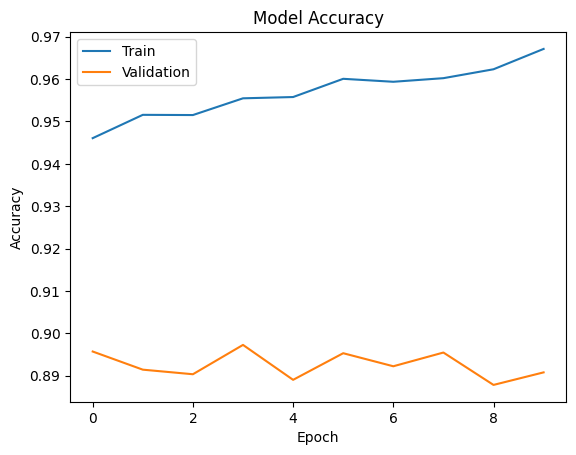

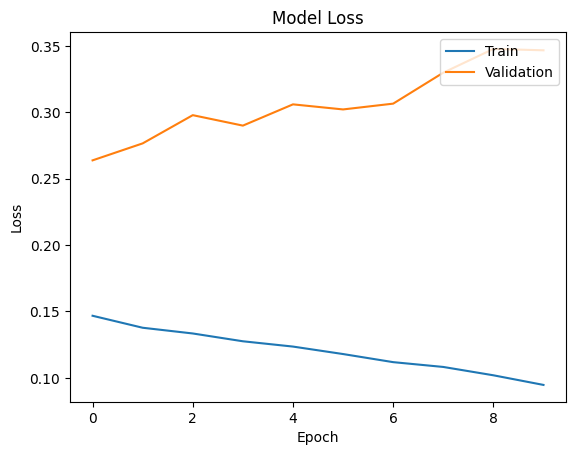

In [ ]:
# Train the model on the training dataset
history = second_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test dataset
loss, accuracy = second_model.evaluate(X_test, y_test)

# Print the test accuracy
print('Test accuracy:', accuracy)

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
def metrics(model, x_train, y_train, x_test, y_test):
    # Get the predicted class labels for the test set
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class labels

    # Calculate the evaluation metrics on the test set
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Visualize the confusion matrix for the test set
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train),
                fmt='d', annot_kws={"fontsize":19})
    plt.xlabel("Predicted", fontsize=16)
    plt.ylabel("Actual", fontsize=16)
    plt.show()

    # Print the evaluation metrics on the test set
    print("\nAccuracy: ", round(acc, 2))
    print("\nF1 Score: ", round(f1, 2))
    print("\nConfusion Matrix: \n", cm)
    print("\nReport:", report)

782/782 [==============================] - 6s 8ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


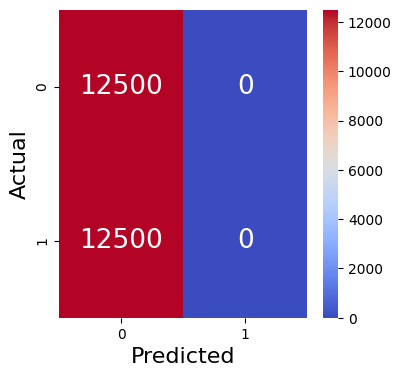


Accuracy:  0.5

F1 Score:  0.33

Confusion Matrix: 
 [[12500     0]
 [12500     0]]

Report:               precision    recall  f1-score   support

           0       0.50      1.00      0.67     12500
           1       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



In [31]:
metrics(model, X_train, y_train, X_test, y_test)
print('hello world there is an error')